## TP 3.1 : Jeu de la minorité avec nombre variable d’agents

*Notebook fait par Alexandre Boistard, Ethan Trentin.*

In [327]:
import numpy as np
import matplotlib.pyplot as plt

In [328]:
# Parameters
T = 2000       # Number of time steps
Ns = 150       # Number of speculators
P = 16         # Number of possible information states mu
Np = 16        # Number of producers (variance for Omega)
epsilon = 0.01 # Minimum performance to keep participating
M = 3          # Memory length (number of signs of A(t) to encode mu)
seed = 10      # Random seed for reproducibility

np.random.seed(seed)  # Ensure reproducibility

In [329]:
# Step 1: Initialize strategies
def initialize(Ns, P, Np):
    ##init agents
    strategies = np.random.choice([-1, 1], size=(Ns, P))
    performance = np.zeros(Ns)
    
    ## init omega and mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    mu = np.random.randint(0, P-1)
    return strategies, performance, Omega, mu

In [330]:
strategies, performance, Omega, mu = initialize(Ns, P, Np)

In [331]:
def simulation(strategies, performance, Omega, mu, M, T=1000, epsilon=0.01):
    A_history = []
    mu_history = [mu]
    
    for t in range(T):
        # Step 1: Get current actions from strategies for current mu
        a_mu_t = strategies[:, mu]
    
        # Step 2: Determine who participates (Heaviside function)
        n_i = (performance >= 0) * 1
        # Step 3: Compute global action A(t)
        A_t = Omega[mu] + (n_i * a_mu_t).sum()
        A_history.append(A_t)
    
        # Step 4: Update performance U_i(t+1)
        performance += -a_mu_t * A_t - epsilon 
    
        # Step 5: Update mu using last M signs of A(t)
        sign = A_t > 0
        mu = (2*mu)%2**M + sign
    return A_history, mu_history

In [332]:
# A_history: time series of global actions A(t)
# mu_history: sequence of encoded market states μ
# performance: final agent performance scores
A_history, mu_history = simulation(strategies, performance, Omega, mu, M, T)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 9
Final A(t): -2.6745306637397146
Top 5 performing agents: [ 51  21 149 118   2]


## Q2 : Explosion de A(t)

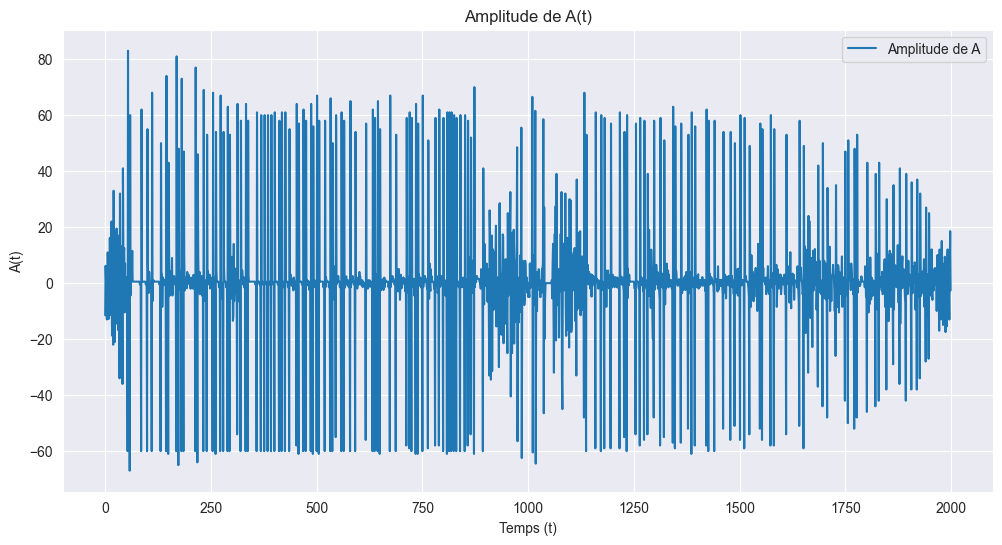

In [333]:
plt.figure(figsize=(12, 6))

plt.plot([t for t in range(len(A_history))],A_history, label=f'Amplitude de A')
    
plt.title("Amplitude de A(t)")
plt.xlabel("Temps (t)")
plt.ylabel("A(t)")
plt.legend()
plt.grid(True)
plt.show()

## Q3 : fluctuations, prévisibilité 

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1,)

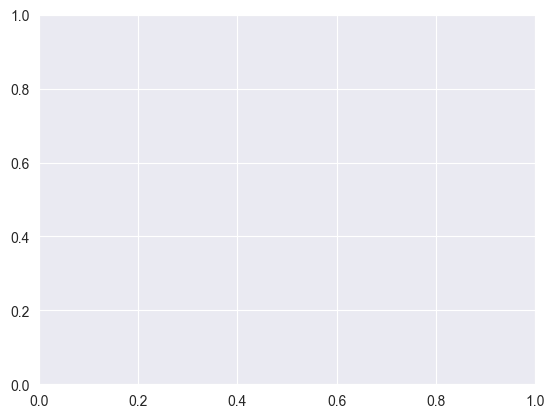

In [335]:
sigma2_P = np.var(A_history) / P

H0_sum = 0
for mu_val in range(P):
    A_mu = A_history[mu_history[:-1] == mu_val]  # Filter A(t) where μ(t) = mu_val
    H0_sum += np.mean(A_mu)**2  # <A|μ>²

H_0 = H0_sum / P

plt.plot([t for t in range(T)], sigma2_P, label=f'Variance de A')
plt.plot([t for t in range(T)], H_0, label=f'previsibilite')
plt.show()